# Analysis of Call Quality Data

In this notebook, we import, process and analyze the dataset chosen. The dataset is created using multiple excel files each corresponding to a month of call quality data from various regions of India and such regions wherein the network operators have customers.

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import sys
import operator
from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser

# Helper files to implement data analysis algorithms from scratch
from apriori_helper import loadData, generateOneItemsets, returnItemsWithMinSupport, joinSet, getSupport, subsets
from knn_scratch import KNN
from NB_scratch import NBClassify
from misc_helper import labelEncode, test_train_split

In [125]:
# Creating paths to save plots and data
cwd = os.getcwd()
parent = os.path.abspath(os.path.join(cwd, os.pardir))
plots_path = os.path.join(parent, "plots")
data_path = os.path.join(parent, "data")

### 1. Data Overview
To get an initial idea of the given data `head()` function of pandas dataframe is used to display the first few datapoints. Here we get to notice the raw data and the available attributes for analysis.

In [126]:
df = pd.read_excel(os.path.join(data_path, "final_data.xlsx"))
df.head()

,Operator,Indoor_Outdoor_Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name,Month,Year
0,Airtel,Indoor,3G,5,Satisfactory,28.422966,76.912324,Haryana,April,2018
1,RJio,Indoor,4G,4,Satisfactory,11.158358,77.301897,Tamil Nadu,April,2018
2,Airtel,Outdoor,3G,5,Satisfactory,28.422931,76.912253,Haryana,April,2018
3,Airtel,Travelling,3G,5,Satisfactory,28.422947,76.912260,Haryana,April,2018
4,RJio,Indoor,4G,5,Satisfactory,25.625990,85.094294,Bihar,April,2018


We notice that the data contains majorly categorical data both nominal and ordinal. The only continuous quantitative data attribute is `Latitude` and `Longitude`. The rest of the data attributes can be catagorized as follows:
* Operator - Ordinal
* Indoor_Outdoor_Travelling - Ordinal
* Network Type - Ordinal
* Rating - Nominal
* Call Drop Category - Nominal
* State Name - Ordinal
* Month - Ordinal
* Year - Nominal

The call quality data was collected for three different environments - Indoor, Outdoor and Travelling. The cell below lists the number of records collected for each environment. The figure shows that most of the collected data is from indoor environments.

Indoor        505623
Outdoor       187835
Travelling    108670
Name: Indoor_Outdoor_Travelling, dtype: int64


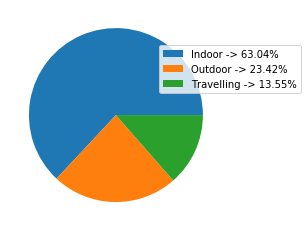

In [127]:
environment_counts = df['Indoor_Outdoor_Travelling'].value_counts()
print(environment_counts)
f, axes = plt.subplots(1,1)
env_df = dict(environment_counts)

axes.pie(df['Indoor_Outdoor_Travelling'].value_counts().values)
percentages = df['Indoor_Outdoor_Travelling'].value_counts().values / sum(df['Indoor_Outdoor_Travelling'].value_counts().values) *100
labels = ['{0} -> {1:1.2f}%'.format(i,j) for i,j in zip(env_df.keys(),percentages)]
axes.legend(labels = labels ,loc = (0.7,0.6))
plt.savefig(os.path.join(plots_path, 'in_out_pie.png'))

The distribution of network types can be seen below

4G         504797
3G         146627
Unknown    117214
2G          35947
Name: Network Type, dtype: int64


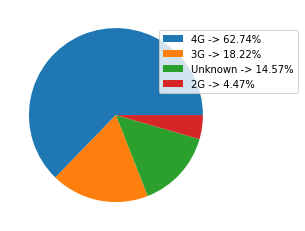

In [128]:
network_counts = df['Network Type'].value_counts()
print(network_counts)
f, axes = plt.subplots(1,1)

network_df = dict(network_counts)
axes.pie(df['Network Type'].value_counts().values)
percentages = df['Network Type'].value_counts().values / sum(df['Network Type'].value_counts().values) *100
labels = ['{0} -> {1:1.2f}%'.format(i,j) for i,j in zip(network_df.keys(),percentages)]
axes.legend(labels = labels ,loc = (0.7,0.6))
plt.savefig(os.path.join(plots_path, 'network_pie.png'))

### 2. Data Preprocessing

#### (a) NA Handling

Below we can see that the dataset contains many NA values. Owing to the type of data, the NA values cannot be assumed or given a value as:
* The data attribute having NA is a catagorical values
* NA values of state do not have coordinates provided as well which makes it not possible to pinpoint their location as all the operators present in the database are distributed throughout India.

We therefore decide to remove the NA containing rows.

In [129]:
len(df) - df.count()

Operator                          0
Indoor_Outdoor_Travelling      2457
Network Type                      0
Rating                            0
Call Drop Category                0
Latitude                          0
Longitude                         0
State Name                   268073
Month                             0
Year                              0
dtype: int64

In [130]:
df = df.dropna()
df = df.reset_index(drop=True)
len(df) - df.count()

Operator                     0
Indoor_Outdoor_Travelling    0
Network Type                 0
Rating                       0
Call Drop Category           0
Latitude                     0
Longitude                    0
State Name                   0
Month                        0
Year                         0
dtype: int64

In [131]:
print(df['Operator'].value_counts())
print('====================================')
print(df['Indoor_Outdoor_Travelling'].value_counts())
print('====================================')
print(df['State Name'].value_counts())

RJio        224263
Airtel      120823
Vodafone     94171
BSNL         45585
Idea         44137
MTNL          3163
Tata          1368
Other          703
RComm          339
Telenor        155
Aircel          42
Name: Operator, dtype: int64
Indoor        332520
Outdoor       124166
Travelling     78063
Name: Indoor_Outdoor_Travelling, dtype: int64
Maharashtra       115086
Uttar Pradesh      43121
West Bengal        42794
Gujarat            38227
Karnataka          31698
                   ...  
Rio de Janeiro         1
West Java              1
Chisinau               1
???????                1
Lower Saxony           1
Name: State Name, Length: 72, dtype: int64


#### (b) Data Aggregation

The data contains the following mobile service operators. The function `value_counts()` has been used to generate a list of the unique operators in the dataset along with the number of records for each operator. From the chart, it can be seen that Reliance Jio, Airtel and Vodafone account for most of the data with BSNL and Idea making up a smaller portion.

In [132]:
df['Operator'].value_counts()

RJio        224263
Airtel      120823
Vodafone     94171
BSNL         45585
Idea         44137
MTNL          3163
Tata          1368
Other          703
RComm          339
Telenor        155
Aircel          42
Name: Operator, dtype: int64

Because the counts of 'RComm', 'Telenor', and 'Aircel' and very small for any valuable analysis, they have been clubbed with 'Other'. 

RJio        224263
Airtel      120823
Vodafone     94171
BSNL         45585
Idea         44137
MTNL          3163
Tata          1368
Other         1239
Name: Operator, dtype: int64


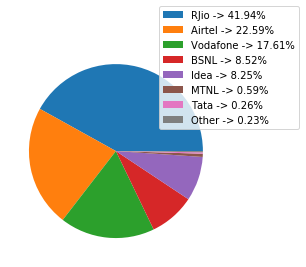

In [133]:
df = df.replace(to_replace = ['RComm', 'Telenor', 'Aircel'], value = 'Other')
print(df['Operator'].value_counts())

operator_df = dict(df['Operator'].value_counts())

f, axes = plt.subplots(1,1)

# df['Operator'].value_counts().plot(kind='pie',ax = axes)
axes.pie(df['Operator'].value_counts().values)
percentages = df['Operator'].value_counts().values / sum(df['Operator'].value_counts().values) *100
labels = ['{0} -> {1:1.2f}%'.format(i,j) for i,j in zip(operator_df.keys(),percentages)]
axes.legend(labels =labels ,loc = (0.7,0.6))
plt.savefig(os.path.join(plots_path, 'Operator_pie.png'))

Similarly, states with counts less than 50 have been clubbed into the category 'Other'

In [134]:
df['State Name'].value_counts()
state_names = df['State Name'].unique()
for state in state_names:
    if len(df[df['State Name'] == state])<50:
        df = df.replace(to_replace=state, value='Other')
df['State Name'].value_counts()

Maharashtra                    115086
Uttar Pradesh                   43121
West Bengal                     42794
Gujarat                         38227
Karnataka                       31698
Telangana                       31187
Tamil Nadu                      30413
N/A-1                           29000
NCT                             27295
Rajasthan                       24531
Andhra Pradesh                  16438
Kerala                          16411
Haryana                         15871
Odisha                          14780
Bihar                           12722
Madhya Pradesh                  10718
Uttarakhand                      6503
Punjab                           5949
Chhattisgarh                     4836
Jharkhand                        3767
Assam                            3442
Delhi                            1815
Goa                              1697
Chandigarh                       1657
Himachal Pradesh                 1615
Meghalaya                        1057
Kashmir     

####  (c) Normalization

The attributes "Latitude" and "Longitude" have been standardized by subtracting the mean and dividing the standard deviation.

In [135]:
df['Latitude'] = (df['Latitude'] - df['Latitude'].mean())/df['Latitude'].std()
df['Longitude'] = (df['Longitude'] - df['Longitude'].mean())/df['Longitude'].std()

# Data Analysis

## (a) Association Rule Mining - Apriori Algorithm

Preparing data for running Apriori algorithm

In [178]:
data = df.drop(columns=['Latitude', 'Longitude', 'Month', 'Year', 'Rating'])
data = data.drop(data[data['Network Type'] == 'Unknown'].index)
data = data.drop(data[data['State Name'] == 'Other'].index)
data = data.drop(data[data['State Name'] == 'N/A-1' ].index)
data.to_csv(os.path.join(data_path, 'apriori.csv'), index=False)

In [179]:
data = loadData(os.path.join(data_path, 'apriori.csv'))
freqSet = defaultdict(int)
largeSet = dict()

#### 1. Generate frequent 1-itemsets

In [180]:
# Parameters
minSupport = 0.3
minConfidence = 0.7

itemSet, transactionList = generateOneItemsets(data)
oneCSet = returnItemsWithMinSupport(itemSet,transactionList,minSupport,freqSet)

#### 2. Generate frequent k-itemsets

In [181]:
currentLSet = oneCSet
k = 2

while(currentLSet != set([])):
        
    largeSet[k-1] = currentLSet
        
    # Generate k-itemsets
    currentLSet = joinSet(currentLSet, k)

    # Get frequent k-itemsets
    currentCSet = returnItemsWithMinSupport(currentLSet,transactionList,minSupport,freqSet)
        
    currentLSet = currentCSet
    k = k + 1

The generated frequent itemsets are: 

In [182]:
frequent_itemsets = []

# Loop to store frequent itemsets
for key, value in largeSet.items():
    frequent_itemsets.extend([(tuple(item), getSupport(item, freqSet, transactionList)) for item in value])

for item in frequent_itemsets:
    print("Itemset: ", item[0], " Support: ", item[1])

Itemset:  ('RJio',)  Support:  0.4802776857359344
Itemset:  ('4G',)  Support:  0.744832204501271
Itemset:  ('Satisfactory',)  Support:  0.6817805809990106
Itemset:  ('Indoor',)  Support:  0.6167431708170458
Itemset:  ('Indoor', 'Satisfactory')  Support:  0.419976504227617
Itemset:  ('4G', 'RJio')  Support:  0.47667453720974956
Itemset:  ('4G', 'Satisfactory')  Support:  0.5188649734571921
Itemset:  ('Satisfactory', 'RJio')  Support:  0.34346694719475773
Itemset:  ('4G', 'Indoor')  Support:  0.44761300099405193
Itemset:  ('4G', 'Indoor', 'Satisfactory')  Support:  0.3141991857579472
Itemset:  ('4G', 'Satisfactory', 'RJio')  Support:  0.3410733443474594


#### 3. Generate association rules from frequent itemsets

In [183]:
association_rules = []
for key, value in list(largeSet.items())[1:]:
    for item in value:
        _subsets = map(frozenset, [x for x in subsets(item)])
        for element in _subsets:
            remain = item.difference(element)
            if len(remain) > 0:
                confidence = getSupport(item, freqSet, transactionList)/getSupport(element, freqSet, transactionList)
                if confidence >= minConfidence:
                    association_rules.append(((tuple(element), tuple(remain)),confidence))

The generated association rules are:

In [184]:
for rule in association_rules:
    print(rule[0][0], " -> ", rule[0][1], " Confidence: ", rule[1])

('RJio',)  ->  ('4G',)  Confidence:  0.9924977806939673
('Satisfactory',)  ->  ('4G',)  Confidence:  0.7610439310208881
('RJio',)  ->  ('Satisfactory',)  Confidence:  0.7151424215523564
('Indoor',)  ->  ('4G',)  Confidence:  0.7257688810742169
('4G', 'Indoor')  ->  ('Satisfactory',)  Confidence:  0.7019438333117639
('Indoor', 'Satisfactory')  ->  ('4G',)  Confidence:  0.7481351518361582
('RJio',)  ->  ('4G', 'Satisfactory')  Confidence:  0.7101586321355514
('4G', 'RJio')  ->  ('Satisfactory',)  Confidence:  0.7155266701342136
('RJio', 'Satisfactory')  ->  ('4G',)  Confidence:  0.9930310533026601


## (b) Chi Square tests

Chi square tests a sample of the given data to conduct a hypothesis testing wherein:

$H_0$ : The given distribution between two variables follow uniform distribution

$H_1$ : The given distribution between two variables do not follow uniform distribution. i.e. there exists a correlated relation between them.

To conduct a chi square analysis first a crosstabulation of both selected variables are created as shown below.







In [143]:
sample = df.sample(frac = 0.01, random_state = 1)
sample.head()

,Operator,Indoor_Outdoor_Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name,Month,Year
225949,RJio,Indoor,4G,4,Satisfactory,-2.833617,-4.036763,N/A-1,September,2018
180826,RJio,Indoor,4G,3,Poor Voice Quality,-1.160931,0.213453,Tamil Nadu,August,2018
484051,Vodafone,Indoor,4G,5,Satisfactory,0.372750,0.790367,West Bengal,October,2019
487457,Airtel,Indoor,4G,1,Poor Voice Quality,-0.939725,0.348770,Tamil Nadu,October,2019
470901,Vodafone,Indoor,3G,4,Satisfactory,-0.931267,0.349728,Tamil Nadu,September,2019


In [144]:
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(sample['Indoor_Outdoor_Travelling'],sample['Call Drop Category'])
cross_tab

Call Drop Category,Call Dropped,Poor Network,Poor Voice Quality,Satisfactory
Indoor_Outdoor_Travelling,,,,
Indoor,316,42,690,2196
Outdoor,76,28,330,876
Travelling,47,7,215,524


Once a cross tab is recieved chi square analysis is conducted to give us statistical checkpoints for drawing conclusions. 
As seen here, a low p-value suggests that the null hypothesis is rejected and the variables have a relationship with each other.



In [145]:
[chi_val,p,dof,ef] = chi2_contingency(cross_tab)
print(p) #lower means reject null - relation exists

1.0855742081027125e-07


In [146]:
cross_tab2 = pd.crosstab(sample['Network Type'],sample['Call Drop Category'])
cross_tab2

Call Drop Category,Call Dropped,Poor Network,Poor Voice Quality,Satisfactory
Network Type,,,,
2G,14,6,65,120
3G,104,14,218,607
4G,267,45,773,2319
Unknown,54,12,179,550


In [147]:
[chi_val,p,dof,ef] = chi2_contingency(cross_tab2)
print(p)

0.0014833997461713077


In [148]:
cross_tab3 = pd.crosstab(sample['Operator'],sample['Call Drop Category'])
cross_tab3 = cross_tab3.drop(['Other','Tata','MTNL'])
cross_tab3

Call Drop Category,Call Dropped,Poor Network,Poor Voice Quality,Satisfactory
Operator,,,,
Airtel,149,16,338,765
BSNL,36,6,95,317
Idea,30,8,120,237
RJio,144,37,487,1589
Vodafone,77,8,185,655


In [149]:
[chi_val,p,dof,ef] = chi2_contingency(cross_tab3)
print(p)

7.131498332863261e-11


## (c) K Nearest Neighbor Classification

As the volume of the data is quite large, the KNN classifier implemented is shown on a small sample of data. For further analysis sklearn's KNN classifier is used to conduct the classification as the library implements a graph based optimization instead of iterative procedure to find K nearest neighbors.

Below, a fraction of 1% of the data is taken

In [150]:
sample = df.sample(frac = 0.01, random_state = 1)
sample.head()

,Operator,Indoor_Outdoor_Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name,Month,Year
225949,RJio,Indoor,4G,4,Satisfactory,-2.833617,-4.036763,N/A-1,September,2018
180826,RJio,Indoor,4G,3,Poor Voice Quality,-1.160931,0.213453,Tamil Nadu,August,2018
484051,Vodafone,Indoor,4G,5,Satisfactory,0.372750,0.790367,West Bengal,October,2019
487457,Airtel,Indoor,4G,1,Poor Voice Quality,-0.939725,0.348770,Tamil Nadu,October,2019
470901,Vodafone,Indoor,3G,4,Satisfactory,-0.931267,0.349728,Tamil Nadu,September,2019


#### Removing unused features and dirty data

In [151]:
sample = sample.drop(['Rating','Month','Year','State Name'],axis = 1);
sample = sample.drop(sample[(sample.Latitude == -1) & (df.Longitude == -1)].index)
sample = sample.drop(sample[(sample.Latitude <= 0) | (sample.Longitude <= 0)].index)
sample.head()

D:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Operator,Indoor_Outdoor_Travelling,Network Type,Call Drop Category,Latitude,Longitude
484051,Vodafone,Indoor,4G,Satisfactory,0.372750,0.790367
112122,BSNL,Travelling,3G,Satisfactory,0.564175,0.234557
192049,RJio,Travelling,4G,Poor Voice Quality,1.174317,0.175349
203467,Vodafone,Indoor,2G,Satisfactory,1.163509,0.184593
511229,RJio,Outdoor,4G,Satisfactory,0.357859,0.785955


#### One-hot encoding categorical data

In [152]:
sample['Operator'] = sample['Operator'].astype('category')
sample['Indoor_Outdoor_Travelling'] = sample['Indoor_Outdoor_Travelling'].astype('category')
sample['Network Type'] = sample['Network Type'].astype('category')
sample2 = pd.get_dummies(sample)

#### Feature and Target processing

Once X and Y are defined, they are encoded and split into test and train datasets to conduct and validate classification.

In [153]:
Y = np.array(sample['Call Drop Category'])
X = sample2.iloc[:,:-4]
X = np.array(X)

In [154]:
Y = labelEncode(Y)

X_train, X_test, y_train, y_test = test_train_split(X,Y, p = 0.8)

#### Model fitting and validation

In [155]:
classifier = KNN(num_clusters= 5)
classifier.fit(X_train,y_train)
classifier.predict(X_test)
classifier.score(X_test,y_test)

0.7075268817204301

Below, the majority of the dataset is used instead of a small sample. `sklearn` based KNN classifier is used here as the library uses graph based optimization which exponentially reduces computational strain of the method. The entire dataset has been used for classification.

In [156]:
sample = df.sample(frac = 1, random_state = 1)
sample = sample.drop(['Rating','Month','Year','State Name'],axis = 1);
sample = sample.drop(sample[(sample.Latitude == -1) & (df.Longitude == -1)].index)
sample = sample.drop(sample[(sample.Latitude <= 0) | (sample.Longitude <= 0)].index)
sample['Operator'] = sample['Operator'].astype('category')
sample['Indoor_Outdoor_Travelling'] = sample['Indoor_Outdoor_Travelling'].astype('category')
sample['Network Type'] = sample['Network Type'].astype('category')

sample2 = pd.get_dummies(sample)

Y = np.array(sample['Call Drop Category'])
X = sample2.iloc[:,:-4]
X = np.array(X)

Y = labelEncode(Y)

X_train, X_test, y_train, y_test = test_train_split(X,Y, p = 0.8)


from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=  5)
classifier.fit(X_train,y_train)
print(classifier.score(X_test,y_test))

D:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


0.8160874230777654


## (b) Naive Bayes Classification

#### Preparing data for classification

In [185]:
# Generate a random sample of the values.
sample = df.sample(frac = 1.0, random_state = 1)

# Remove the columns of non-used attributes
keep = ['Operator','Indoor_Outdoor_Travelling']
non_var = list(df.columns.difference(keep))
Y = sample['Call Drop Category']
Y_labels = ['Call Dropped','Poor Voice Quality','Poor Network','Satisfactory']
sample = sample.drop(non_var, axis = 1)
sample = sample.astype('category')
X = pd.get_dummies(sample)

In [186]:
# Splitting the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

#### Filling conditional probabilities

In [187]:
# Conditional probabilities P(X_column|Call Dropped),...
probabilities = {'Call Dropped': {},'Poor Network': {},'Poor Voice Quality': {},'Satisfactory': {}}

In [188]:
# Count of observations with ycol and xcol
def cnt(x,y,xcol,ycol):
    tempx,tempy = x[y == ycol], y[y == ycol]
    tempx,tempy = tempx[x[xcol] == 1], tempy[x[xcol] == 1]
    return len(tempy)

In [189]:
# Filling in conditional probabilities P(explanatory_attribute|predction_labels)

def fillProb(X_tr, Y_tr, cntCDC, probCDC):
    for col in list(X_train.columns):
        probabilities['Call Dropped'][col] = {}
        probabilities['Poor Voice Quality'][col] = {}
        probabilities['Poor Network'][col] = {}
        probabilities['Satisfactory'][col] = {}
    
        cnt_CallDropped = cnt(X_tr, Y_tr,col,'Call Dropped')
        cnt_PoorVoiceQuality = cnt(X_tr, Y_tr,col,'Poor Voice Quality')
        cnt_PoorNetwork = cnt(X_tr, Y_tr,col,'Poor Network')
        cnt_Satisfactory = cnt(X_tr, Y_tr,col,'Satisfactory')
    
        if (probCDC['Call Dropped'] != 0):
            probabilities['Call Dropped'][col] = cnt_CallDropped/cntCDC['Call Dropped']
        else:
            probabilities['Call Dropped'][col] = 0
        if (probCDC['Poor Voice Quality'] != 0):
            probabilities['Poor Voice Quality'][col] = cnt_PoorVoiceQuality/cntCDC['Poor Voice Quality']
        else:
            probabilities['Poor Voice Quality'][col] = 0
        if (probCDC['Poor Network'] != 0):
            probabilities['Poor Network'][col] = cnt_PoorNetwork/cntCDC['Poor Network']
        else:
            probabilities['Poor Network'][col] = 0
        if (probCDC['Satisfactory'] != 0):
            probabilities['Satisfactory'][col] = cnt_Satisfactory/cntCDC['Satisfactory']
        else:
            probabilities['Satisfactory'][col] = 0

#### Classification and Validation

In [190]:
# Running the Classifier
nbc = NBClassify()
nbc.fitNB(X_train,Y_train)

In [191]:
# Generating predictions
predictions = nbc.predict(X_test)
res = nbc.score(predictions,Y_test)
res

0.6821754714040829